In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Load Datasets
events = pd.read_csv("C:/Users/arpit/Customer Purchase Propensity & Recommender System for E-Commerce/events.csv")
categories = pd.read_csv("C:/Users/arpit/Customer Purchase Propensity & Recommender System for E-Commerce/category_tree.csv")

# ✅ Merge item_properties_part1.csv and item_properties_part2.csv
part1 = pd.read_csv("C:/Users/arpit/Customer Purchase Propensity & Recommender System for E-Commerce/item_properties_part1.csv")
part2 = pd.read_csv("C:/Users/arpit/Customer Purchase Propensity & Recommender System for E-Commerce/item_properties_part2.csv")

item_properties = pd.concat([part1, part2])
item_properties.to_csv("C:/Users/arpit/Customer Purchase Propensity & Recommender System for E-Commerce/item_properties.csv", index=False)
print("✅ Merged item_properties saved.")

# Step 3: Basic Exploration
print(events.head())
print(events['event'].value_counts())

# ✅ Convert event timestamps from milliseconds
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms')

# Step 4: Filter Relevant Events (last 90 days if needed)
events = events.sort_values('timestamp')
latest_date = events['timestamp'].max()
start_date = latest_date - pd.Timedelta(days=90)
filtered_events = events[events['timestamp'] >= start_date]

# Step 5: Create "Purchased" Label
purchases = filtered_events[filtered_events['event'] == 'transaction']
purchases.loc[:, 'purchase'] = 1  # ✅ Fix SettingWithCopyWarning

# Merge label with views
viewed = filtered_events[filtered_events['event'] == 'view']
merged = viewed.merge(purchases[['visitorid', 'itemid', 'purchase']],
                    on=['visitorid', 'itemid'], how='left')
merged['purchase'] = merged['purchase'].fillna(0)

# Step 6: Feature Engineering
user_view_counts = merged.groupby('visitorid')['itemid'].count().reset_index(name='user_total_views')
item_view_counts = merged.groupby('itemid')['visitorid'].count().reset_index(name='item_total_views')

merged = merged.merge(user_view_counts, on='visitorid', how='left')
merged = merged.merge(item_view_counts, on='itemid', how='left')

# Step 7: Add Item Metadata (from merged item_properties - with aggressive property filtering)
item_properties['timestamp'] = pd.to_datetime(item_properties['timestamp'], unit='ms')  # ✅ Fix timestamp error

# Analyze property value counts
property_counts = item_properties['property'].value_counts()
print("Number of unique properties:", len(property_counts))
print("Top 20 properties:\n", property_counts.head(20))

# Identify properties to keep (e.g., top N most frequent)
top_n = 20  # Try keeping only the top 20 most frequent properties (or even fewer)
frequent_properties = property_counts.nlargest(top_n).index
filtered_item_properties = item_properties[item_properties['property'].isin(frequent_properties)]
print("Number of properties after filtering:", filtered_item_properties['property'].nunique())

# Remove duplicate item-properties and pivot the filtered data
latest_filtered_items = filtered_item_properties.sort_values('timestamp').drop_duplicates(['itemid', 'property'], keep='last')
try:
    pivot_filtered_items = latest_filtered_items.pivot(index='itemid', columns='property', values='value').reset_index()
    print("✅ Pivoted filtered item properties successfully.")

    merged = merged.merge(pivot_filtered_items, on='itemid', how='left')

    # Step 8: Save Cleaned Data
    merged.to_csv("C:/Users/arpit/Customer Purchase Propensity & Recommender System for E-Commerce/cleaned_user_item_data_reduced_properties.csv", index=False)
    print("✅ Cleaned data with aggressively reduced properties saved as 'cleaned_user_item_data_reduced_properties.csv'!")

except MemoryError as e:
    print(f"❌ MemoryError during pivoting: {e}")
    print("Consider reducing the number of top_n properties further or exploring other memory-saving techniques.")

✅ Merged item_properties saved.
       timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN
3  1433221955914     483717  view  253185            NaN
4  1433221337106     951259  view  367447            NaN
event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64


C:\Users\arpit\AppData\Local\Temp\ipykernel_22928\1680761411.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases.loc[:, 'purchase'] = 1  # ✅ Fix SettingWithCopyWarning


Number of unique properties: 1104
Top 20 properties:
 property
888           3000398
790           1790516
available     1503639
categoryid     788214
6              631471
283            597419
776            574220
678            481966
364            476486
202            448938
839            417239
917            417227
112            417053
764            417053
159            417053
227            347492
698            289849
451            264416
663            240813
962            239372
Name: count, dtype: int64
Number of properties after filtering: 20
✅ Pivoted filtered item properties successfully.
✅ Cleaned data with aggressively reduced properties saved as 'cleaned_user_item_data_reduced_properties.csv'!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1713844 entries, 0 to 1713843
Data columns (total 28 columns):
 #   Column            Dtype         
---  ------            -----         
 0   timestamp         datetime64[ns]
 1   visitorid         int64         
 2   event             object        
 3   itemid            int64         
 4   transactionid     float64       
 5   purchase          float64       
 6   user_total_views  int64         
 7   item_total_views  int64         
 8   112               float64       
 9   159               float64       
 10  202               object        
 11  227               object        
 12  283               object        
 13  364               float64       
 14  451               object        
 15  6                 object        
 16  663               object        
 17  678               object        
 18  698               object        
 19  764               float64       
 20  776               float64       
 21  790     

C:\Users\arpit\AppData\Local\Temp\ipykernel_22928\224367284.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
C:\Users\arpit\AppData\Local\Temp\ipykernel_22928\224367284.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

✅ Numerical column '159' imputed with median: 519769.0

Column '202' has 9.92% missing values.


C:\Users\arpit\AppData\Local\Temp\ipykernel_22928\224367284.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_val, inplace=True)


✅ Categorical column '202' imputed with mode: 678458 452490 n53904.000

Column '227' has 20.95% missing values.
✅ Categorical column '227' imputed with mode: 977762

Column '283' has 9.66% missing values.
✅ Categorical column '283' imputed with mode: 619728 1090933 678458 452490 n53904.000 1090933 921669 1113810 619728 1144520 418473 150169 642930 61218 216382 593601 602565 783232 519519 1306028 1025024 1818 942064 93792 1243756 698513 148839 697681 386817 379482 253420 880137 1053265

Column '364' has 9.66% missing values.
✅ Numerical column '364' imputed with median: 655203.0


C:\Users\arpit\AppData\Local\Temp\ipykernel_22928\224367284.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)



Column '6' has 11.99% missing values.
✅ Categorical column '6' imputed with mode: 977762


C:\Users\arpit\AppData\Local\Temp\ipykernel_22928\224367284.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_val, inplace=True)



Column '678' has 9.66% missing values.
✅ Categorical column '678' imputed with mode: 820477

Column '764' has 9.66% missing values.
✅ Numerical column '764' imputed with median: 1285872.0

Column '776' has 9.91% missing values.


C:\Users\arpit\AppData\Local\Temp\ipykernel_22928\224367284.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
C:\Users\arpit\AppData\Local\Temp\ipykernel_22928\224367284.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

✅ Numerical column '776' imputed with median: 663679.0

Column '790' has 9.66% missing values.


C:\Users\arpit\AppData\Local\Temp\ipykernel_22928\224367284.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_val, inplace=True)


✅ Categorical column '790' imputed with mode: n47880.000

Column '839' has 10.72% missing values.
✅ Categorical column '839' imputed with mode: 820477

Column '888' has 9.66% missing values.
✅ Categorical column '888' imputed with mode: 678458 452490 n53904.000

Column '917' has 9.66% missing values.
✅ Categorical column '917' imputed with mode: 914932

Column 'available' has 9.66% missing values.
✅ Numerical column 'available' imputed with median: 0.0

Column 'categoryid' has 9.66% missing values.
✅ Numerical column 'categoryid' imputed with median: 926.0

✅ Missing values imputation complete.


C:\Users\arpit\AppData\Local\Temp\ipykernel_22928\224367284.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
C:\Users\arpit\AppData\Local\Temp\ipykernel_22928\224367284.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

timestamp           0
visitorid           0
event               0
itemid              0
purchase            0
user_total_views    0
item_total_views    0
112                 0
159                 0
202                 0
227                 0
283                 0
364                 0
6                   0
678                 0
764                 0
776                 0
790                 0
839                 0
888                 0
917                 0
available           0
categoryid          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1713844 entries, 0 to 1713843
Data columns (total 23 columns):
 #   Column            Dtype         
---  ------            -----         
 0   timestamp         datetime64[ns]
 1   visitorid         int64         
 2   event             object        
 3   itemid            int64         
 4   purchase          float64       
 5   user_total_views  int64         
 6   item_total_views  int64         
 7   112               flo

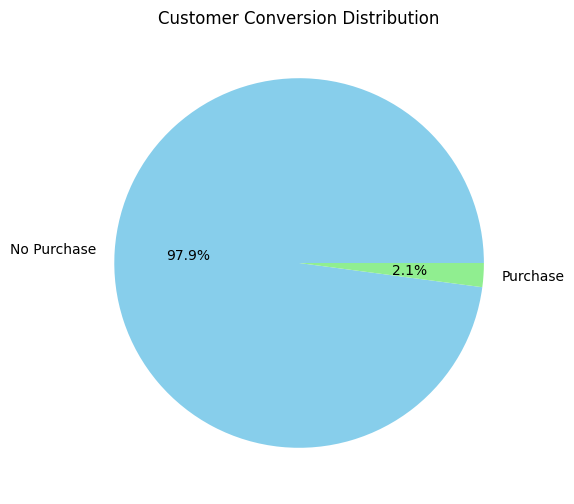

C:\Users\arpit\AppData\Local\Temp\ipykernel_22928\224367284.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='hour', palette='viridis')


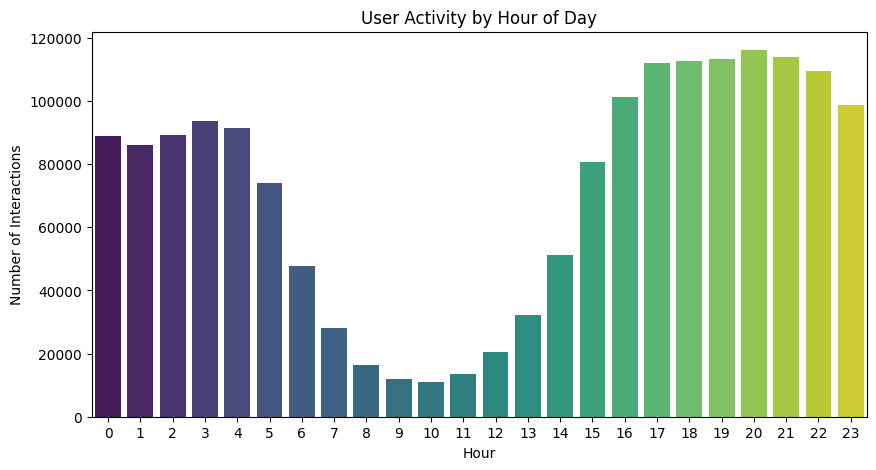

C:\Users\arpit\AppData\Local\Temp\ipykernel_22928\224367284.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='day_of_week', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], palette='coolwarm')


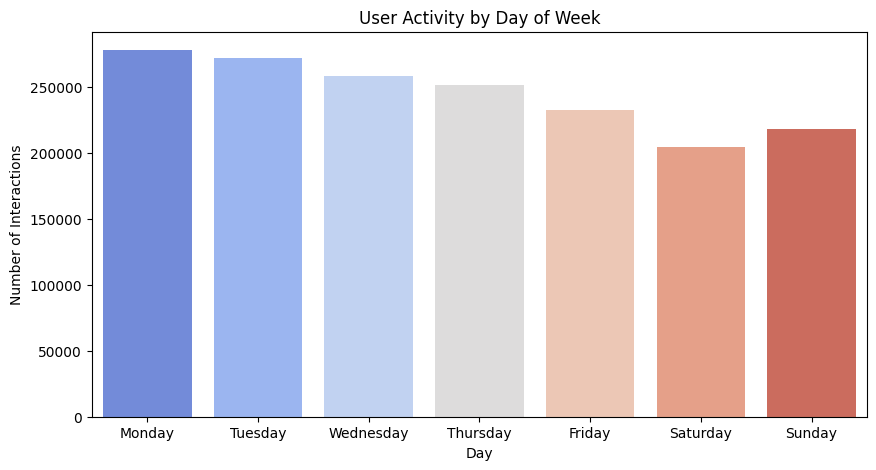

C:\Users\arpit\AppData\Local\Temp\ipykernel_22928\224367284.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=funnel_df, x='Stage', y='Count', palette='Blues_d')


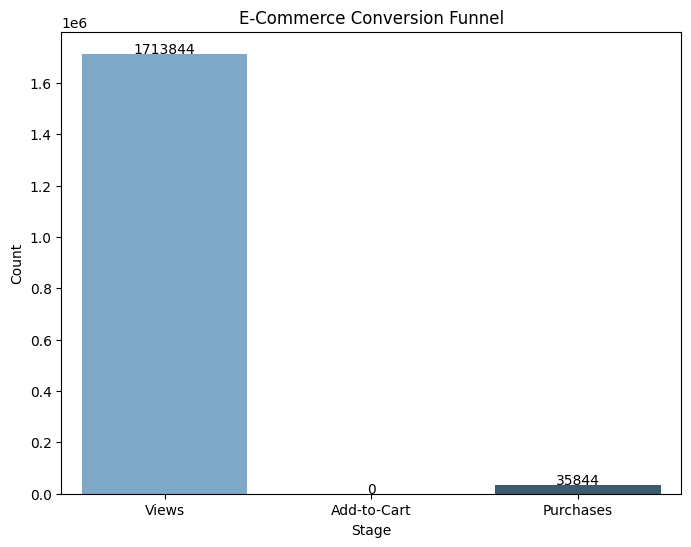

✅ Funnel Summary:
          Stage    Count
0        Views  1713844
1  Add-to-Cart        0
2    Purchases    35844


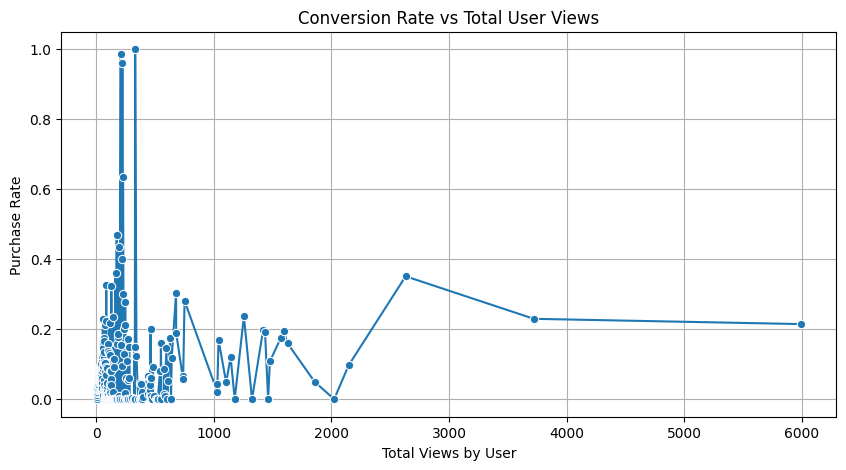

Top 10 Viewed Items:
 itemid
187946    3395
461686    2015
219512    1644
384302    1452
190000    1144
5411      1127
320130    1082
441668    1037
119736     975
96924      956
Name: count, dtype: int64
Top 10 Purchased Items:
 itemid
119736    690
461686    403
382885    377
263245    214
356339    212
248455    182
312728    154
9877      147
445351    139
48030     124
Name: count, dtype: int64

✅ No missing values found after handling.

Missing Value Counts per Column (After Handling):
 Series([], dtype: int64)

Missing Value Percentages per Column (After Handling):
 Series([], dtype: float64)


In [2]:
# Step 1: Load Cleaned Data
df = pd.read_csv("C:/Users/arpit/Customer Purchase Propensity & Recommender System for E-Commerce/cleaned_user_item_data_reduced_properties.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Optional: Quick overview
print(df.info())
print(df['purchase'].value_counts())

# Step 2: Remove High Missing Value Columns
columns_to_remove = ['transactionid', '451', '663', '962']
print(f"\n✅ Removing columns with high missing values: {columns_to_remove}")
df = df.drop(columns=columns_to_remove, errors='ignore')
print(df.info()) # Print info after removal

# Step 3: Analyze and Handle '698' (Moderate Missing Values)
print("\nℹ️ Analyzing column '698' for potential removal or imputation...")
print(f"Missing percentage in '698': {(df['698'].isnull().sum() / len(df)) * 100:.2f}%")

# For now, let's REMOVE '698' based on the initial recommendation for simplification.
# You might want to revisit this later based on domain knowledge or further analysis.
print("❌ Removing column '698' for simplification (can be revisited).")
df = df.drop(columns=['698'], errors='ignore')
print(df.info()) # Print info after removal

# Step 4: Handle Missing Values in Remaining Columns (Imputation)
print("\n🛠️ Handling missing values in remaining columns...")

for col in df.columns:
    if df[col].isnull().any():
        missing_percentage = (df[col].isnull().sum() / len(df)) * 100
        print(f"\nColumn '{col}' has {missing_percentage:.2f}% missing values.")
        if df[col].dtype in ['int64', 'float64']:
            # Impute numerical columns with the median
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"✅ Numerical column '{col}' imputed with median: {median_val}")
        elif df[col].dtype == 'object':
            # Impute categorical columns with the mode
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
            print(f"✅ Categorical column '{col}' imputed with mode: {mode_val}")
        else:
            print(f"⚠️ Column '{col}' with dtype '{df[col].dtype}' - Skipping imputation for now. Investigate further.")

print("\n✅ Missing values imputation complete.")
print(df.isnull().sum()) # Verify no missing values remain (for handled columns)
print(df.info()) # Final info after handling missing values

# Step 5: EVENT DISTRIBUTION
event_dist = df['purchase'].value_counts(normalize=True) * 100
print("\n✅ Purchase Distribution:\n", event_dist)

# Pie Chart - Purchase vs Non-Purchase
plt.figure(figsize=(6, 6))
plt.pie(event_dist, labels=['No Purchase', 'Purchase'], autopct='%.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Customer Conversion Distribution')
plt.show()

# Step 6: SESSION BEHAVIOR ANALYSIS (Temporal Patterns)
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()

# Plot: Views by Hour of Day
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='hour', palette='viridis')
plt.title('User Activity by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Interactions')
plt.show()

# Plot: Views by Day of Week
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='day_of_week', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], palette='coolwarm')
plt.title('User Activity by Day of Week')
plt.xlabel('Day')
plt.ylabel('Number of Interactions')
plt.show()

# Step 7: CONVERSION FUNNEL
funnel_data = {
    "Stage": ["Views", "Add-to-Cart", "Purchases"],
    "Count": [
        df.shape[0],
        df[df['event'] == 'addtocart'].shape[0],
        df[df['purchase'] == 1].shape[0]
    ]
}
funnel_df = pd.DataFrame(funnel_data)

# Plot Funnel
plt.figure(figsize=(8, 6))
sns.barplot(data=funnel_df, x='Stage', y='Count', palette='Blues_d')
plt.title('E-Commerce Conversion Funnel')
for i in range(len(funnel_df)):
    plt.text(i, funnel_df['Count'][i] + 1000, funnel_df['Count'][i], ha='center')
plt.show()
print("✅ Funnel Summary:\n", funnel_df)

# Step 8: INSIGHTS FOR MODELING

# Correlation of views vs purchase rate
view_to_purchase = df.groupby('user_total_views')['purchase'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(data=view_to_purchase, x='user_total_views', y='purchase', marker='o')
plt.title("Conversion Rate vs Total User Views")
plt.xlabel("Total Views by User")
plt.ylabel("Purchase Rate")
plt.grid(True)
plt.show()

# Popular items (top 10 viewed & top 10 purchased)
top_items_viewed = df['itemid'].value_counts().head(10)
top_items_purchased = df[df['purchase'] == 1]['itemid'].value_counts().head(10)

print("Top 10 Viewed Items:\n", top_items_viewed)
print("Top 10 Purchased Items:\n", top_items_purchased)

# Optional: Visualize missing value percentages per column (after handling)
missing_percentages = (df.isnull().sum() / len(df)) * 100
missing_percentages = missing_percentages[missing_percentages > 0].sort_values(ascending=False)

if not missing_percentages.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_percentages.index, y=missing_percentages.values, palette='magma')
    plt.ylabel('Percentage of Missing Values')
    plt.xlabel('Columns')
    plt.title('Missing Value Percentage per Column (After Handling)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\n✅ No missing values found after handling.")

# Optional: Alternatively, print missing value counts and percentages (after handling)
missing_counts = df.isnull().sum()
missing_percentages = (missing_counts / len(df)) * 100
print("\nMissing Value Counts per Column (After Handling):\n", missing_counts[missing_counts > 0])
print("\nMissing Value Percentages per Column (After Handling):\n", missing_percentages[missing_percentages > 0])

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import warnings
import pandas as pd
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import time
from imblearn.over_sampling import SMOTE # For handling class imbalance

warnings.filterwarnings('ignore')

df = pd.read_csv("C:/Users/arpit/Customer Purchase Propensity & Recommender System for E-Commerce/cleaned_user_item_data_reduced_properties.csv")

# Drop columns not needed for modeling
df_model = df.drop(columns=['timestamp', 'event'])

# Identify categorical columns
cat_cols = df_model.select_dtypes(include='object').columns.tolist()
if 'categoryid' in df_model.columns:
    cat_cols.append('categoryid')

# Fill missing values with 'missing' (as string)
df_model = df_model.fillna('missing').astype(str)

# Encode categorical columns
le = LabelEncoder()
for col in cat_cols:
    df_model[col] = le.fit_transform(df_model[col])
    # Explicitly convert to integer after label encoding
    df_model[col] = df_model[col].astype(int)

# Convert remaining object columns (if any) to string and then encode
object_cols_after_fill = df_model.select_dtypes(include='object').columns
for col in object_cols_after_fill:
    df_model[col] = df_model[col].astype(str)
    df_model[col] = le.fit_transform(df_model[col]).astype(int)

# Define features and target
X = df_model.drop(columns=['purchase'])
y = df_model['purchase']

# Train-Test Split (using a smaller training set for faster initial experiments)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.8, random_state=42)

# --- Address Class Imbalance using SMOTE ---
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("\n✅ Class imbalance addressed using SMOTE.")
print(f"Shape of y_train before SMOTE: {y_train.shape}")
print(f"Shape of y_train after SMOTE: {y_train_resampled.shape}")

# Identify numerical columns *before* label encoding or check if any left
numerical_cols = [col for col in X.columns if df[col].dtype in ['int64', 'float64']]

if len(numerical_cols) == 0:
    print("⚠️ No numerical columns found for scaling. Skipping scaling step.")
    X_train_processed = X_train_resampled.copy()
    X_test_processed = X_test.copy()
else:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled[numerical_cols])
    X_test_scaled = scaler.transform(X_test[numerical_cols])

    # Convert back to DataFrame
    X_train_processed_numerical = pd.DataFrame(X_train_scaled, columns=numerical_cols, index=X_train_resampled.index)
    X_test_processed_numerical = pd.DataFrame(X_test_scaled, columns=numerical_cols, index=X_test.index)

    # Combine with categorical columns
    categorical_cols_train = [col for col in X_train_resampled.columns if col not in numerical_cols]
    X_train_processed = pd.concat([X_train_processed_numerical, X_train_resampled[categorical_cols_train].astype(int)], axis=1)
    categorical_cols_test = [col for col in X_test.columns if col not in numerical_cols]
    X_test_processed = pd.concat([X_test_processed_numerical, X_test[categorical_cols_test].astype(int)], axis=1)


print("\nStarting Model Training (on a smaller sample with balanced training data)...")

# Logistic Regression
start_time = time.time()
log_model = LogisticRegression(solver='saga', max_iter=1000, random_state=42, n_jobs=-1)
log_model.fit(X_train_processed, y_train_resampled)
y_pred_log = log_model.predict(X_test_processed)
y_proba_log = log_model.predict_proba(X_test_processed)[:, 1]
log_time = time.time() - start_time
print(f"\n📊 Logistic Regression Performance (Time: {log_time:.2f}s)")
print(classification_report(y_test, y_pred_log))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_log))

# Random Forest
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
rf_model.fit(X_train_processed, y_train_resampled)
y_pred_rf = rf_model.predict(X_test_processed)
y_proba_rf = rf_model.predict_proba(X_test_processed)[:, 1]
rf_time = time.time() - start_time
print(f"\n📊 Random Forest Performance (Time: {rf_time:.2f}s)")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rf))

# LightGBM
start_time = time.time()
lgbm_model = LGBMClassifier(random_state=42, n_jobs=-1, scale_pos_weight=(y_train_resampled == 0).sum() / (y_train_resampled == 1).sum())
lgbm_model.fit(X_train_processed, y_train_resampled)
y_pred_lgbm = lgbm_model.predict(X_test_processed)
y_proba_lgbm = lgbm_model.predict_proba(X_test_processed)[:, 1]
lgbm_time = time.time() - start_time
print(f"\n📊 LightGBM Performance (Time: {lgbm_time:.2f}s)")
print(classification_report(y_test, y_pred_lgbm))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_lgbm))

# XGBoost
start_time = time.time()
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1, scale_pos_weight=(y_train_resampled == 0).sum() / (y_train_resampled == 1).sum())
xgb_model.fit(X_train_processed, y_train_resampled)
y_pred_xgb = xgb_model.predict(X_test_processed)
y_proba_xgb = xgb_model.predict_proba(X_test_processed)[:, 1]
xgb_time = time.time() - start_time
print(f"\n📊 XGBoost Performance (Time: {xgb_time:.2f}s)")
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_xgb))


✅ Class imbalance addressed using SMOTE.
Shape of y_train before SMOTE: (342768,)
Shape of y_train after SMOTE: (671198,)

Starting Model Training (on a smaller sample with balanced training data)...

📊 Logistic Regression Performance (Time: 646.58s)
              precision    recall  f1-score   support

           0       0.98      0.52      0.68   1342401
           1       0.02      0.54      0.04     28675

    accuracy                           0.52   1371076
   macro avg       0.50      0.53      0.36   1371076
weighted avg       0.96      0.52      0.66   1371076

ROC AUC Score: 0.5601353983267084

📊 Random Forest Performance (Time: 135.50s)
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1342401
           1       0.60      0.53      0.56     28675

    accuracy                           0.98   1371076
   macro avg       0.79      0.76      0.78   1371076
weighted avg       0.98      0.98      0.98   1371076

ROC AUC Score: 

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import time
import numpy as np

# Assuming X_train_processed, y_train_resampled, X_test_processed, y_test are already defined

# --- Faster Hyperparameter Tuning for Random Forest using RandomizedSearchCV ---
print("\n⏭️ Next Step: Faster Hyperparameter Tuning for Random Forest using RandomizedSearchCV...")

# Define a smaller parameter distribution for faster search
param_distributions_rf_fast = {
    'n_estimators': [50, 100],  # Fewer options
    'max_depth': [None, 10],     # Fewer options
    'min_samples_split': [2, 5], # Fewer options
    'min_samples_leaf': [1, 3],  # Fewer options
    'class_weight': ['balanced', 'balanced_subsample']
}

# Use RandomizedSearchCV instead of GridSearchCV
n_iter_rf_fast = 5  # Number of random hyperparameter combinations to try
random_search_rf = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
                                   param_distributions=param_distributions_rf_fast,
                                   n_iter=n_iter_rf_fast,
                                   scoring='roc_auc',
                                   cv=3,
                                   n_jobs=-1,
                                   verbose=1,
                                   random_state=42)

start_time = time.time()
random_search_rf.fit(X_train_processed, y_train_resampled)
rf_tuning_time_fast = time.time() - start_time

print(f"\n✅ Random Forest Tuning Completed (Time: {rf_tuning_time_fast:.2f}s)")
print(f"Best parameters for Random Forest (fast search): {random_search_rf.best_params_}")
best_rf_model_fast = random_search_rf.best_estimator_

y_pred_rf_tuned_fast = best_rf_model_fast.predict(X_test_processed)
y_proba_rf_tuned_fast = best_rf_model_fast.predict_proba(X_test_processed)[:, 1]
print("\n📊 Tuned Random Forest Performance (fast search):")
print(classification_report(y_test, y_pred_rf_tuned_fast))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rf_tuned_fast))


⏭️ Next Step: Faster Hyperparameter Tuning for Random Forest using RandomizedSearchCV...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score
import time
import numpy as np

# Assuming X_train_processed, y_train_resampled, X_test_processed, y_test are already defined

# --- Faster Hyperparameter Tuning for LightGBM using RandomizedSearchCV ---
print("\n⏭️ Next Step: Faster Hyperparameter Tuning for LightGBM using RandomizedSearchCV...")

# Define a smaller parameter distribution for faster search
param_distributions_lgbm_fast = {
    'n_estimators': [50, 100],  # Fewer options
    'learning_rate': [0.01, 0.1], # Fewer options
    'num_leaves': [20, 31],     # Fewer options
    'max_depth': [-1, 5],        # Fewer options
    'scale_pos_weight': [(y_train_resampled == 0).sum() / (y_train_resampled == 1).sum()], # Keep the calculated weight
    'subsample': [0.8, 1.0],     # Add subsample for potential speedup
    'colsample_bytree': [0.8, 1.0] # Add colsample_bytree for potential speedup
}

# Use RandomizedSearchCV instead of GridSearchCV
n_iter_lgbm_fast = 5  # Number of random hyperparameter combinations to try
random_search_lgbm = RandomizedSearchCV(estimator=LGBMClassifier(random_state=42, n_jobs=-1),
                                    param_distributions=param_distributions_lgbm_fast,
                                    n_iter=n_iter_lgbm_fast,
                                    scoring='roc_auc',
                                    cv=3,
                                    n_jobs=-1,
                                    verbose=1,
                                    random_state=42)

start_time = time.time()
random_search_lgbm.fit(X_train_processed, y_train_resampled)
lgbm_tuning_time_fast = time.time() - start_time

print(f"\n✅ LightGBM Tuning Completed (Time: {lgbm_tuning_time_fast:.2f}s)")
print(f"Best parameters for LightGBM (fast search): {random_search_lgbm.best_params_}")
best_lgbm_model_fast = random_search_lgbm.best_estimator_

y_pred_lgbm_tuned_fast = best_lgbm_model_fast.predict(X_test_processed)
y_proba_lgbm_tuned_fast = best_lgbm_model_fast.predict_proba(X_test_processed)[:, 1]
print("\n📊 Tuned LightGBM Performance (fast search):")
print(classification_report(y_test, y_pred_lgbm_tuned_fast))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_lgbm_tuned_fast))

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# --- Threshold Optimization for LightGBM ---
print("\n⏭️ Next Step: Threshold Optimization for LightGBM...")

# Get probability predictions from the tuned model
y_proba_lgbm_tuned = best_lgbm_model_fast.predict_proba(X_test_processed)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_lgbm_tuned)

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Tuned LightGBM')
plt.grid(True)
plt.show()

# You can analyze this curve to choose a threshold that balances precision and recall
# based on your business needs. For example, finding the threshold with a good F1-score.

# Example of finding a threshold with a high F1-score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7) # Avoid division by zero
best_f1_index = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_index]
best_precision = precision[best_f1_index]
best_recall = recall[best_f1_index]
best_f1 = f1_scores[best_f1_index]

print(f"\nOptimal Threshold for LightGBM (based on max F1-score): {best_threshold:.4f}")
print(f"Precision at this threshold: {best_precision:.4f}")
print(f"Recall at this threshold: {best_recall:.4f}")
print(f"F1-Score at this threshold: {best_f1:.4f}")

# You can then use this optimal threshold to make predictions:
y_pred_lgbm_optimized = (y_proba_lgbm_tuned >= best_threshold).astype(int)
print("\n📊 LightGBM Performance with Optimized Threshold:")
print(classification_report(y_test, y_pred_lgbm_optimized))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_lgbm_tuned))

In [ ]:
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'best_rf_model_fast' and 'X_test_processed', 'y_test' are already defined
# from the Random Forest tuning step

# --- Threshold Optimization for Random Forest ---
print("\n⏭️ Next Step: Threshold Optimization for Random Forest...")

# Get probability predictions from the tuned Random Forest model
y_proba_rf_tuned = best_rf_model_fast.predict_proba(X_test_processed)[:, 1]

# Calculate precision-recall curve
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_proba_rf_tuned)

# Plot Precision-Recall Curve for Random Forest
plt.figure(figsize=(10, 6))
plt.plot(recall_rf, precision_rf, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Tuned Random Forest')
plt.grid(True)
plt.show()

# Analyze the curve and choose a threshold based on your business needs.
# Example: Finding the threshold that maximizes the F1-score

f1_scores_rf = 2 * (precision_rf * recall_rf) / (precision_rf + recall_rf + 1e-7) # Avoid division by zero
best_f1_index_rf = np.argmax(f1_scores_rf)
best_threshold_rf = thresholds_rf[best_f1_index_rf]
best_precision_rf = precision_rf[best_f1_index_rf]
best_recall_rf = recall_rf[best_f1_index_rf]
best_f1_rf = f1_scores_rf[best_f1_index_rf]

print(f"\nOptimal Threshold for Random Forest (based on max F1-score): {best_threshold_rf:.4f}")
print(f"Precision at this threshold: {best_precision_rf:.4f}")
print(f"Recall at this threshold: {best_recall_rf:.4f}")
print(f"F1-Score at this threshold: {best_f1_rf:.4f}")

# Apply the optimal threshold to make predictions
y_pred_rf_optimized = (y_proba_rf_tuned >= best_threshold_rf).astype(int)

print("\n📊 Random Forest Performance with Optimized Threshold:")
print(classification_report(y_test, y_pred_rf_optimized))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rf_tuned))

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Plot ROC Curves
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, label='Logistic Regression', linestyle='--')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Updated ROC Curves
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_proba_lgbm)  # Corrected: y_proba_svm to y_proba_lgbm

plt.figure(figsize=(10, 7))
plt.plot(fpr_log, tpr_log, label='Logistic Regression', linestyle='--')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost', linestyle=':')
plt.plot(fpr_lgbm, tpr_lgbm, label='LightGBM', linestyle='-.')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('🔍 ROC Curve Comparison – All Models')
plt.legend()
plt.grid(True)

# Add these lines to save the plot
plt.savefig("roc_curve_comparison.png")  # Save as PNG
plt.savefig("roc_curve_comparison.pdf")  # Save as PDF
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import time
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split as surprise_train_test_split
from collections import defaultdict
import matplotlib.pyplot as plt
import random

# Load data
data_path = "C:/Users/arpit/Customer Purchase Propensity & Recommender System for E-Commerce/cleaned_user_item_data_reduced_properties.csv"
merged = pd.read_csv(data_path)
merged['timestamp'] = pd.to_datetime(merged['timestamp'])

# 🔹 Optimized Train-Test Split (vectorized)
merged.sort_values(by=['visitorid', 'timestamp'], inplace=True)
test_data = merged.groupby('visitorid').tail(1)
train_data = merged.drop(test_data.index)

print(f"Train Size: {train_data.shape}, Test Size: {test_data.shape}")

# 🔹 Prepare Surprise Dataset
reader = Reader(rating_scale=(0, 1))
data_train = Dataset.load_from_df(train_data[['visitorid', 'itemid', 'purchase']], reader)
trainset = data_train.build_full_trainset()

# 🔹 Train SVD (Fast Config)
start = time.time()
svd = SVD(n_factors=20, n_epochs=5, random_state=42)
svd.fit(trainset)
print(f"✅ SVD trained in {time.time() - start:.2f} sec")

# 🔹 Predict on test set (fast)
testset = list(zip(test_data['visitorid'], test_data['itemid'], test_data['purchase']))
predictions = svd.test(testset)

# 🔹 Get Top-N Recommendations
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for pred in predictions:
        top_n[pred.uid].append((pred.iid, pred.est))
    for uid in top_n:
        top_n[uid] = sorted(top_n[uid], key=lambda x: x[1], reverse=True)[:n]
        top_n[uid] = [iid for iid, _ in top_n[uid]]
    return top_n

top_n = get_top_n(predictions)

# 🔹 Evaluation Metrics (Sampled for speed)
sample_users = random.sample(test_data['visitorid'].unique().tolist(), 1000)

def precision_recall_at_k(top_n_pred, actual_df, k=10, users=None):
    precisions, recalls = [], []
    for user in users:
        actual_items = actual_df[(actual_df['visitorid'] == user) &
                                 (actual_df['purchase'] == 1)]['itemid'].tolist()
        predicted_items = top_n_pred.get(user, [])[:k]
        if not actual_items:
            continue
        hits = len(set(predicted_items) & set(actual_items))
        precisions.append(hits / k)
        recalls.append(hits / len(actual_items))
    return np.mean(precisions), np.mean(recalls)

def ndcg_at_k(top_n_pred, actual_df, k=10, users=None):
    ndcgs = []
    for user in users:
        actual_items = actual_df[(actual_df['visitorid'] == user) &
                                 (actual_df['purchase'] == 1)]['itemid'].tolist()
        predicted_items = top_n_pred.get(user, [])[:k]
        if not actual_items:
            continue
        dcg = sum(1 / np.log2(i + 2) for i, item in enumerate(predicted_items) if item in actual_items)
        idcg = sum(1 / np.log2(i + 2) for i in range(min(len(actual_items), k)))
        ndcgs.append(dcg / idcg if idcg != 0 else 0)
    return np.mean(ndcgs)

# 🔹 Evaluate
precision, recall = precision_recall_at_k(top_n, test_data, users=sample_users)
ndcg_score = ndcg_at_k(top_n, test_data, users=sample_users)

print(f"📌 Precision@10: {precision:.4f}")
print(f"📌 Recall@10:    {recall:.4f}")
print(f"📌 NDCG@10:      {ndcg_score:.4f}")

# 🔹 Visualization
metrics = ['Precision@10', 'Recall@10', 'NDCG@10']
scores = [precision, recall, ndcg_score]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, scores, color=['#6A5ACD', '#20B2AA', '#FF8C00'])
plt.ylim(0, 1)
plt.title("Model Performance Metrics")
plt.ylabel("Score")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.25, yval + 0.01, f"{yval:.2f}")
plt.tight_layout()
plt.show()


In [ ]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import shap
import time
import warnings
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("C:/Users/arpit/Customer Purchase Propensity & Recommender System for E-Commerce/cleaned_user_item_data_reduced_properties.csv")

# Retain IDs
id_cols = ['visitorid', 'itemid']
df_ids = df[id_cols].copy()

# Drop timestamp and event
df_model = df.drop(columns=['timestamp', 'event'])

# Identify categorical columns
cat_cols = df_model.select_dtypes(include='object').columns.tolist()
if 'categoryid' in df_model.columns and 'categoryid' not in cat_cols:
    cat_cols.append('categoryid')

# Fast label encoding using factorize
for col in cat_cols:
    df_model[col], _ = pd.factorize(df_model[col].fillna('missing'))

# Ensure numerics
for col in df_model.columns:
    if col not in cat_cols + ['purchase']:
        df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

# Add back visitorid and itemid
df_model[id_cols] = df[id_cols]

# Feature and target
X = df_model.drop(columns=['purchase'])
y = df_model['purchase']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.8, random_state=42)

# Save identifiers
test_visitors = X_test['visitorid'].values
test_items = X_test['itemid'].values

# Drop ID columns for training
X_train = X_train.drop(columns=id_cols)
X_test = X_test.drop(columns=id_cols)

# Scale numeric columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
if not numerical_cols.empty:
    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

# LightGBM Training with Early Stopping Callback
print("\n🚀 Training LightGBM with Early Stopping...")
start_time = time.time()
lgbm_model = LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    n_estimators=300,
    learning_rate=0.05,
    objective='binary',
    metric='auc'
)

lgbm_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)],
    eval_metric='auc'  # Specify the evaluation metric
)

y_pred = lgbm_model.predict(X_test_scaled)
y_proba = lgbm_model.predict_proba(X_test_scaled)[:, 1]
print(f"✅ Time Taken: {time.time() - start_time:.2f} sec")
# Classification Metrics
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))
print("🎯 ROC AUC Score:", roc_auc_score(y_test, y_proba))

# SHAP Explainability (subset only)
print("\n📈 Generating SHAP Summary...")

# Explain model predictions
explainer = shap.Explainer(lgbm_model, X_train_scaled, feature_names=X_train_scaled.columns)
shap_values = explainer(X_test_scaled.iloc[:100])

# Generate summary plot (bar)
shap.summary_plot(shap_values, X_test_scaled.iloc[:100], plot_type='bar', show=False)

# 🔽 Save the figure
plt.tight_layout()
plt.savefig("shap_summary.png", dpi=300, bbox_inches='tight')
print("✅ SHAP summary saved as 'shap_summary.png'")

# Show the plot (optional)
plt.show()

# MAP@K and MRR Metrics
def apk(actual, predicted, k=5):
    predicted = predicted[:k]
    score, num_hits = 0.0, 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / min(len(actual), k) if actual else 0.0

def mapk(y_true, y_scores, user_ids, item_ids, k=5):
    grouped = pd.DataFrame({
        'user': user_ids,
        'item': item_ids,
        'y_true': y_true,
        'score': y_scores
    })

    # Get top-k predictions per user
    topk = grouped.groupby('user', group_keys=False).apply(lambda x: x.nlargest(k, 'score')).reset_index(drop=True)

    # Ground-truth actuals per user
    actual_items = grouped[grouped['y_true'] == 1].groupby('user')['item'].apply(list).to_dict()
    pred_items = topk.groupby('user')['item'].apply(list).to_dict()

    scores = []
    for user in pred_items:
        actual = actual_items.get(user, [])
        pred = pred_items[user]
        scores.append(apk(actual, pred, k))

    return np.mean(scores)

def mean_reciprocal_rank(y_true, y_scores, user_ids, item_ids, k=5):
    df = pd.DataFrame({
        'user': user_ids,
        'item': item_ids,
        'score': y_scores,
        'label': y_true
    })

    df = df.sort_values(['user', 'score'], ascending=[True, False])
    mrr_total, user_count = 0, 0

    for user, user_df in df.groupby('user'):
        top_k = user_df.head(k)
        relevant = top_k[top_k['label'] == 1]
        if not relevant.empty:
            rank = relevant.index[0] - top_k.index[0] + 1
            mrr_total += 1 / rank
            user_count += 1

    return mrr_total / user_count if user_count > 0 else 0.0

# Evaluation
map5 = mapk(y_test.values, y_proba, test_visitors, test_items, k=5)
mrr5 = mean_reciprocal_rank(y_test.values, y_proba, test_visitors, test_items, k=5)

print(f"\n📌 Mean Average Precision @5: {map5:.4f}")
print(f"📌 Mean Reciprocal Rank @5: {mrr5:.4f}")